Базовое решение задачи

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('./plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('./dataset/')
    
print('After zip extraction:')
print(os.listdir("./dataset/"))

['baseline.ipynb', 'dataset', 'kaggle', 'plates.zip', 'submission.csv', 'train', 'val']
After zip extraction:
['plates']


In [15]:
data_root = './dataset/plates/'
print(os.listdir(data_root))

['test', 'train']


In [16]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 20/20 [00:00<00:00, 160.58it/s]


In [17]:
os.listdir('train')

['cleaned', 'dirty']

In [18]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [19]:
len(train_dataloader), len(train_dataset)

(4, 32)

In [20]:
X_batch, y_batch = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


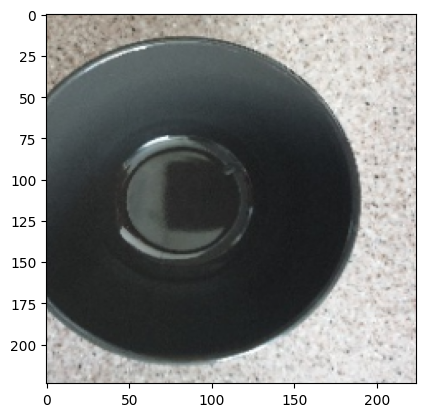

In [21]:
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() )

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

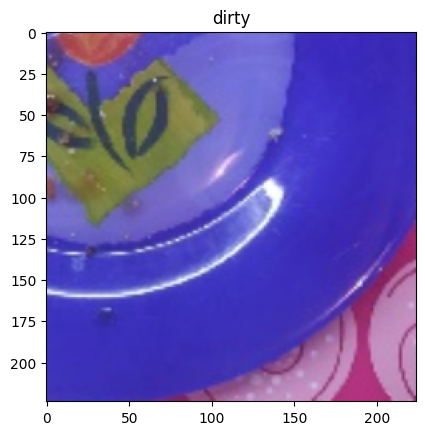

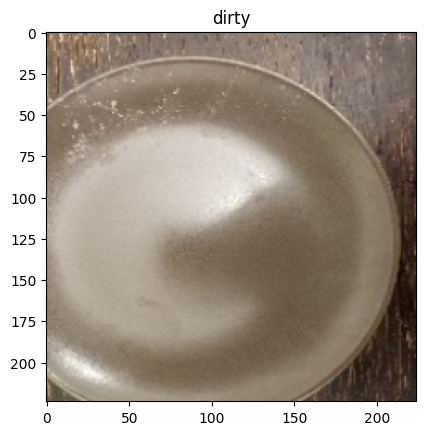

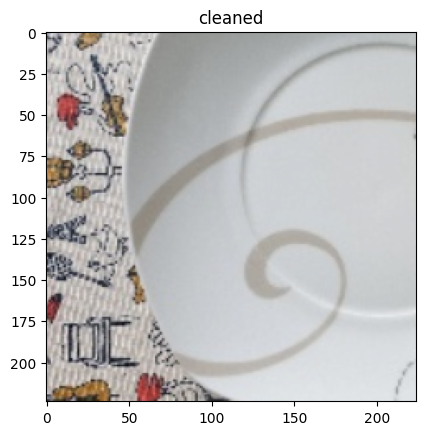

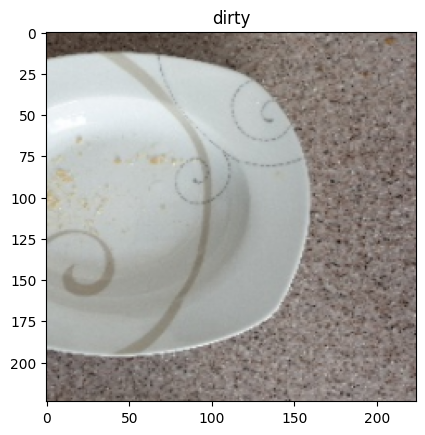

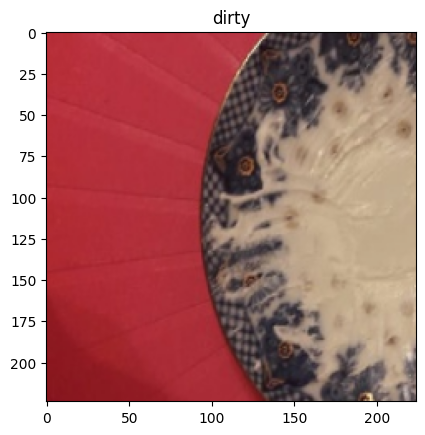

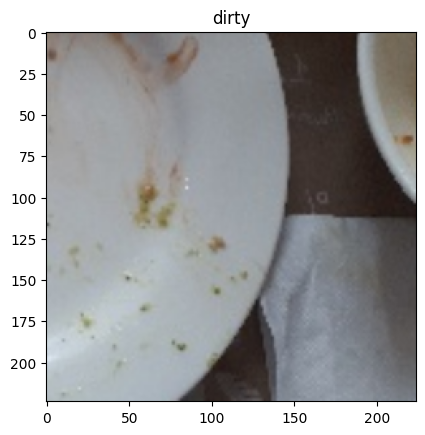

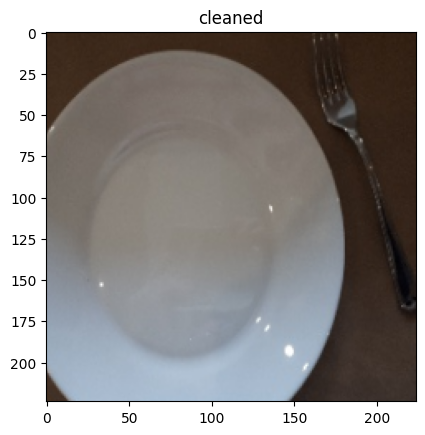

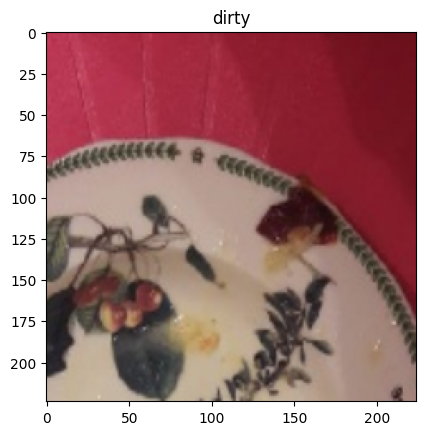

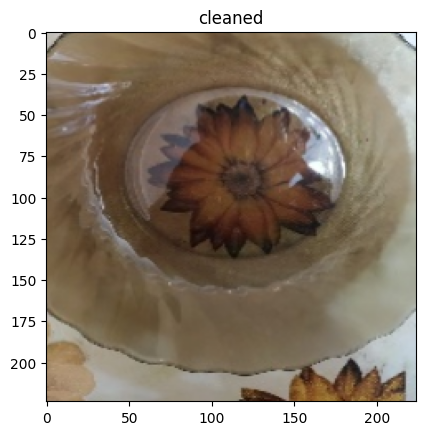

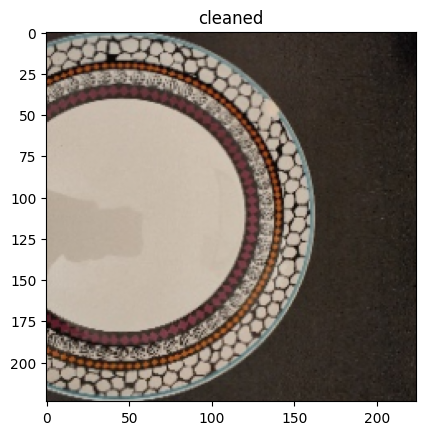

In [22]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [23]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [30]:
model = models.resnet34(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [31]:
train_model(model, loss, optimizer, scheduler, num_epochs=15);

Epoch 0/14:


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]

train Loss: 1.6332 Acc: 0.6250



100%|██████████| 1/1 [00:05<00:00,  5.03s/it]

val Loss: 8.0374 Acc: 0.5000
Epoch 1/14:



100%|██████████| 4/4 [00:05<00:00,  1.29s/it]

train Loss: 0.5926 Acc: 0.8000



100%|██████████| 1/1 [00:05<00:00,  5.59s/it]

val Loss: 3.4808 Acc: 0.7500
Epoch 2/14:



100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

train Loss: 0.7708 Acc: 0.7500



100%|██████████| 1/1 [00:05<00:00,  5.45s/it]

val Loss: 4.2762 Acc: 0.5000
Epoch 3/14:



100%|██████████| 4/4 [00:05<00:00,  1.49s/it]

train Loss: 0.3543 Acc: 0.9500



100%|██████████| 1/1 [00:05<00:00,  5.46s/it]

val Loss: 6.9293 Acc: 0.7500
Epoch 4/14:



100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

train Loss: 0.2275 Acc: 0.9000



100%|██████████| 1/1 [00:06<00:00,  6.14s/it]

val Loss: 8.6312 Acc: 0.6250
Epoch 5/14:



100%|██████████| 4/4 [00:05<00:00,  1.50s/it]

train Loss: 0.5100 Acc: 0.7250



100%|██████████| 1/1 [00:05<00:00,  5.49s/it]

val Loss: 8.0912 Acc: 0.6250
Epoch 6/14:



100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

train Loss: 0.1717 Acc: 0.9250



100%|██████████| 1/1 [00:05<00:00,  5.07s/it]

val Loss: 5.0996 Acc: 0.6250
Epoch 7/14:



100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

train Loss: 0.0810 Acc: 1.0000



100%|██████████| 1/1 [00:05<00:00,  5.15s/it]

val Loss: 3.8292 Acc: 0.6250
Epoch 8/14:



100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

train Loss: 0.6031 Acc: 0.7250



100%|██████████| 1/1 [00:05<00:00,  5.61s/it]

val Loss: 4.0003 Acc: 0.6250
Epoch 9/14:



100%|██████████| 4/4 [00:06<00:00,  1.57s/it]

train Loss: 0.2192 Acc: 0.9250



100%|██████████| 1/1 [00:05<00:00,  5.28s/it]

val Loss: 3.1706 Acc: 0.6250
Epoch 10/14:



100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

train Loss: 0.1825 Acc: 0.9500



100%|██████████| 1/1 [00:05<00:00,  5.75s/it]

val Loss: 2.8164 Acc: 0.6250
Epoch 11/14:



100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

train Loss: 0.3786 Acc: 0.8000



100%|██████████| 1/1 [00:05<00:00,  5.47s/it]

val Loss: 2.4391 Acc: 0.7500
Epoch 12/14:



100%|██████████| 4/4 [00:05<00:00,  1.42s/it]

train Loss: 0.2285 Acc: 0.9250



100%|██████████| 1/1 [00:05<00:00,  5.14s/it]

val Loss: 1.8730 Acc: 0.7500
Epoch 13/14:



100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

train Loss: 0.3447 Acc: 0.8000



100%|██████████| 1/1 [00:05<00:00,  5.44s/it]

val Loss: 1.7898 Acc: 0.7500
Epoch 14/14:



100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

train Loss: 0.6546 Acc: 0.8000



100%|██████████| 1/1 [00:06<00:00,  6.13s/it]

val Loss: 2.1444 Acc: 0.7500


Kaggle submission

In [32]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, test_dir ), os.path.join('kaggle', 'test', 'unknown'))

'kaggle\\test\\unknown'

In [33]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('./kaggle/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [34]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: ./kaggle/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [35]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 75/75 [00:08<00:00,  8.53it/s]


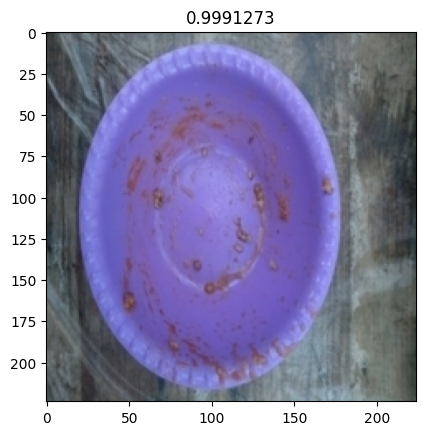

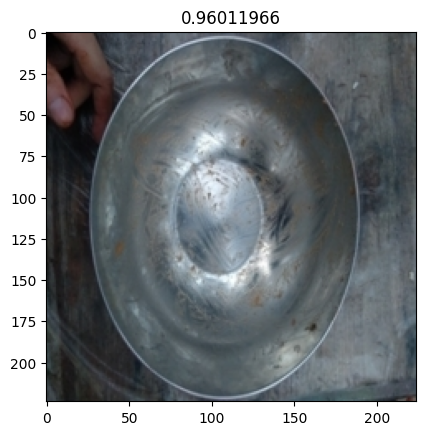

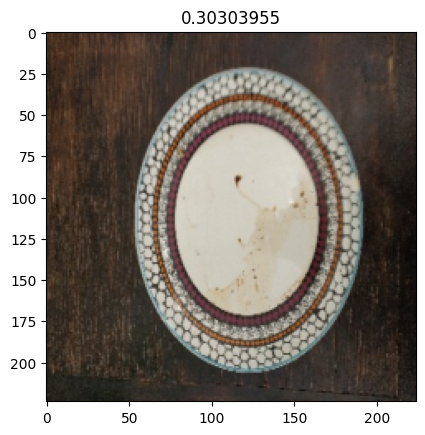

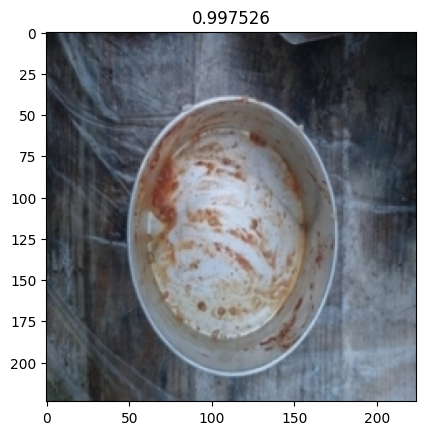

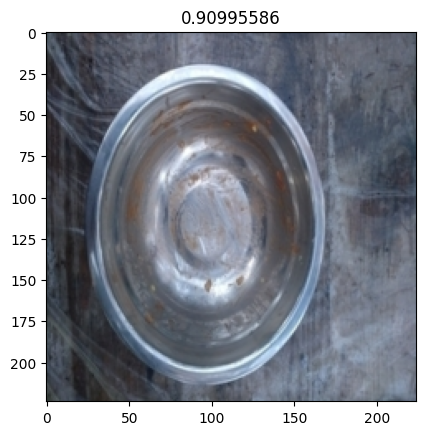

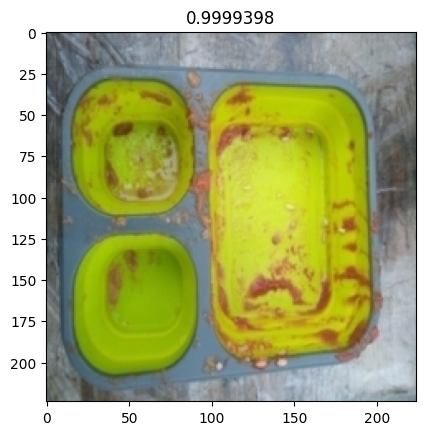

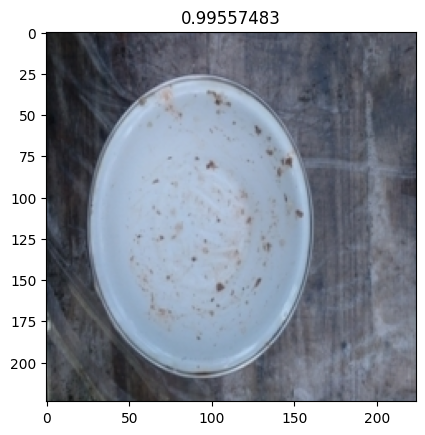

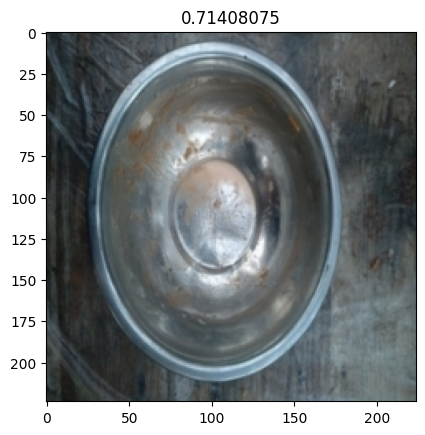

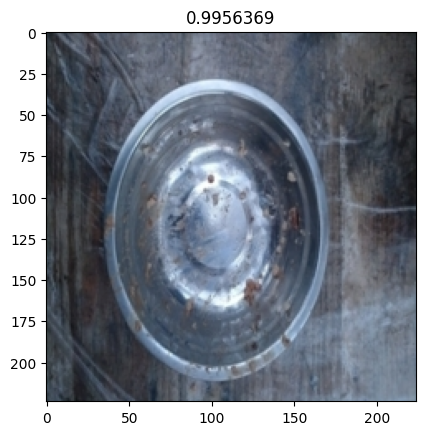

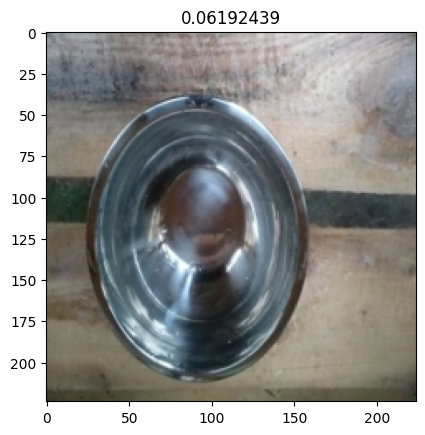

In [36]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [50]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [51]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('./kaggle/test\\unknown\\',"")
#submission_df['id'] = submission_df['id'].str.replace('./kaggle/test/unknown', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id           
0000    dirty
0001    dirty
0002  cleaned
0003    dirty
0004    dirty
0005    dirty

In [52]:
submission_df.to_csv('submission.csv')

### Оценка качества модели по размеченным данным

**Задание 1** Провести оценку модели с помощью метрики accuracy.

In [53]:
# ваш код
test_dataset2 = ImageFolderWithPaths('./dataset/plates/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset2, batch_size=batch_size, shuffle=False, num_workers=2)

**Задание 2**
Получить качество модели > 85%.

In [61]:
import torch
from torchvision import transforms
from PIL import Image
import os

In [ ]:

test_dir = "dataset/plates/test"
cleaned_dir = os.path.join(test_dir, "cleaned")
dirty_dir = os.path.join(test_dir, "dirty")


def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if filename.endswith((".png", ".jpg", ".jpeg")):
            images.append(Image.open(file_path).convert('RGB'))
            filenames.append(filename)
    return images, filenames

In [ ]:
def predict_image(model, image, transform):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  
    with torch.no_grad():
        image = transform(image).unsqueeze(0).to(device)  
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((244, 244)),  
    transforms.ToTensor()
])

In [ ]:
import os
from sklearn.metrics import accuracy_score
from PIL import Image

def load_image(img_path):
    """Загрузка изображения с помощью PIL."""
    return Image.open(img_path).convert('RGB')
# Пути к папкам
cleaned_dir = "dataset/plates/test/cleaned"
dirty_dir = "dataset/plates/test/dirty"

# Получение списков изображений из папок с полными путями
cleaned_images = [(os.path.join(cleaned_dir, img), 0) for img in os.listdir(cleaned_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
dirty_images = [(os.path.join(dirty_dir, img), 1) for img in os.listdir(dirty_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Объединение и сортировка по имени файла
all_images = cleaned_images + dirty_images
all_images.sort(key=lambda x: os.path.basename(x[0]))  # Сортировка по имени файла

# Создание списков файлов и истинных меток
image_paths = [img[0] for img in all_images]
true_labels = [img[1] for img in all_images]



# Предсказание
predicted_labels = []

# Загрузка изображений и предсказания модели
for img_path in image_paths:
    # Загрузка изображения
    img = load_image(img_path)  
    predicted_labels.append(predict_image(model, img, transform))


if len(true_labels) != len(predicted_labels):
    raise ValueError("Размеры списков true_labels и predicted_labels не совпадают!")

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86
